<i><span style="color:#e74c3c;"><b>MAIN GOAL: </b>  I tried to classify spam or ham message FNet (Mixing Tokens with Fourier Transforms) [1] model.</span></i>


* I applied several <b>preprocessing</b> operations (cleaning,dropping stop words etc.),
* Used <b>tf.data pipeline</b> for efficient training,
* I created <b>Vocabulary</b> and trained <b>Tokenizer</b> using the train data,
* I have modified this notebook [2],

## Proposed Model
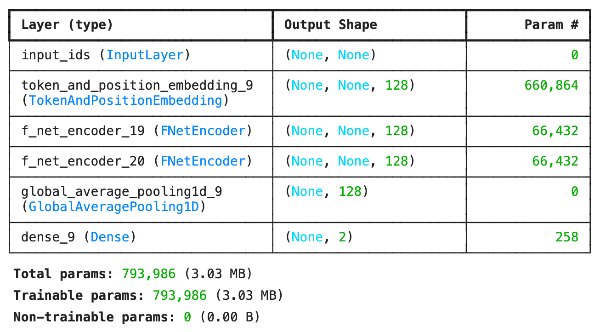


## My Another Projects
* [News Zero-Shot Topic Modelling w/BERTopic](https://www.kaggle.com/code/banddaniel/news-zero-shot-topic-modelling-w-bertopic)
* [Complaint Analysis w/Ensemble Model (CatBoost, LR)](https://www.kaggle.com/code/banddaniel/complaint-analysis-w-ensemble-model-catboost-lr)
* [Gemma 2B Text Summarization w/Zero-Shot Prompting](https://www.kaggle.com/code/banddaniel/gemma-2b-text-summarization-w-zero-shot-prompting)



## References
1. Lee-Thorp, J., Ainslie, J., Eckstein, I., & Ontanon, S. (2021). FNet: Mixing Tokens with Fourier Transforms (Version 4). arXiv. https://doi.org/10.48550/ARXIV.2105.03824
2. https://keras.io/examples/nlp/fnet_classification_with_keras_nlp/


In [1]:
import os
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import *
import keras_nlp
from keras_nlp.layers import *
from tensorflow.keras.models import Model

SEED = 21
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE

VOCAB_SIZE = 5000
EMBED_DIM = 128
INTERMEDIATE_DIM = 256

2024-03-21 12:49:58.010567: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 12:49:58.010689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 12:49:58.149041: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# <span style="color:#e74c3c;"> Reading </span> Data

In [2]:
# reading, dropping and shuffling
data = pd.read_csv('/kaggle/input/telegram-spam-or-ham/dataset.csv')
data.drop_duplicates(subset = ['text'], inplace = True)
data = data.sample(frac = 1, random_state = SEED).reset_index(drop = True)
data.head()

,text_type,text
0,ham,huhdid you read my mission statement?
1,ham,anytime
2,ham,i like the simplicity of this line: friends ar...
3,spam,weekender presents kids mens womens garment wi...
4,ham,project tracking database access hi sandy yes ...


# <span style="color:#e74c3c;"> Preprocessing </span>

In [3]:
# preprocessing functions
stop_words = set(stopwords.words('english'))

def text_preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('@\w+\s*', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('http', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def drop_stopwords(text):
    dropped = [word for word in text.split() if word not in stop_words]
    final_text = ' '.join(dropped)
    return final_text


def delete_one_characters(text):
    deleted = [word if len(word)>1 else "" for word in text.split()]
    final_text = ' '.join(deleted)
    return final_text


# applying preprocessing functions 
full_data = data.copy()
full_data['preprocessed_text'] = data['text'].apply(text_preprocessing).apply(drop_stopwords).apply(delete_one_characters)


# label encoding
LE = LabelEncoder()
full_data['encoded_text_type'] = LE.fit_transform(full_data['text_type'].tolist())

full_data.shape[0]

20334

In [4]:
# calculating max token numbers and dropping samples have 0,1 or 2 tokens
full_data['max']= full_data['preprocessed_text'].apply(lambda X: len(X.split()))

drop_idx = full_data[(full_data['max'] == 0) | (full_data['max'] == 1) | (full_data['max'] == 2)].index
full_data.drop(index = drop_idx, inplace = True)


# set the max sequence length of full dataset
MAX_SEQUENCE_LENGTH = full_data['max'].max()

print('final sample size: \t', full_data.shape[0])
print('max sequence length: \t', MAX_SEQUENCE_LENGTH)

final sample size: 	 19058
max sequence length: 	 163


In [5]:
# final dataframe
full_data.head()

,text_type,text,preprocessed_text,encoded_text_type,max
0,ham,huhdid you read my mission statement?,huhdid read mission statement,0,4
2,ham,i like the simplicity of this line: friends ar...,like simplicity line friends like blood though...,0,11
3,spam,weekender presents kids mens womens garment wi...,weekender presents kids mens womens garment wi...,1,15
4,ham,project tracking database access hi sandy yes ...,project tracking database access hi sandy yes ...,0,76
5,ham,university of texas conference on energy finan...,university texas conference energy finance feb...,0,76


# <span style="color:#e74c3c;"> Dataset </span> Splitting

In [6]:
# train,validation and test splitting

train_val_data, test_data = train_test_split(full_data, test_size = 0.2, random_state = SEED, stratify = full_data['encoded_text_type'])
train_data, val_data = train_test_split(train_val_data, test_size = 0.2, random_state = SEED, stratify = train_val_data['encoded_text_type'])


train_data.reset_index(drop = True, inplace = True)
val_data.reset_index(drop = True, inplace = True)
test_data.reset_index(drop = True, inplace = True)

print('train samples :\t', train_data.shape[0])
print('val samples :\t', val_data.shape[0])
print('test samples :\t', test_data.shape[0])

train samples :	 12196
val samples :	 3050
test samples :	 3812


# <span style="color:#e74c3c;"> Create </span> Vocabulary and Tokenizer

In [7]:
train_dataset_for_vocab = tf.data.Dataset.from_tensor_slices(train_data['preprocessed_text'].values)
reserved_tokens = ["[PAD]", "[UNK]"]

# creating vocabulary
vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(train_dataset_for_vocab, VOCAB_SIZE, reserved_tokens = reserved_tokens)

# creating tokenizer
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(vocabulary = vocab, lowercase = True, sequence_length = MAX_SEQUENCE_LENGTH)

# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [8]:
# a function for tf.data pipeline
def format_dataset(sentence, label):
    sentence = tokenizer(sentence)
    return ({"input_ids": sentence}, label)

In [9]:
# tf.datasets
train_loader = tf.data.Dataset.from_tensor_slices((train_data['preprocessed_text'], train_data['encoded_text_type']))
train_dataset = (train_loader.map(format_dataset, num_parallel_calls = AUTO).shuffle(BATCH_SIZE*10).batch(BATCH_SIZE).prefetch(AUTO))

val_loader = tf.data.Dataset.from_tensor_slices((val_data['preprocessed_text'], val_data['encoded_text_type']))
val_dataset = (val_loader.map(format_dataset, num_parallel_calls = AUTO).batch(BATCH_SIZE).prefetch(AUTO))

test_loader = tf.data.Dataset.from_tensor_slices((test_data['preprocessed_text'], test_data['encoded_text_type']))
test_dataset = (test_loader.map(format_dataset, num_parallel_calls = AUTO).batch(BATCH_SIZE).prefetch(AUTO))

# <span style="color:#e74c3c;"> FNet </span>  Model

In [10]:
inp = Input(shape=(None,), dtype=tf.int64, name = "input_ids")
emb = TokenAndPositionEmbedding(vocabulary_size = VOCAB_SIZE, sequence_length = MAX_SEQUENCE_LENGTH, embedding_dim = EMBED_DIM, mask_zero = True)(inp)

X = FNetEncoder(INTERMEDIATE_DIM, 0.2, activation = 'gelu')(emb)
X = FNetEncoder(INTERMEDIATE_DIM, 0.1, activation = 'gelu')(X)

X = GlobalAveragePooling1D()(X)
out = Dense(2, activation = 'softmax')(X)

model = Model(inputs = inp, outputs = out)

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-05, weight_decay = 0.005), metrics = ['acc'])

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3, min_delta = 0.001),
                tf.keras.callbacks.ModelCheckpoint('/kaggle/working/fnet_model.best.weights.h5', save_best_only=True, save_weights_only=True)]
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:847: UserWarning: Layer 'f_net_encoder' (of type FNetEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)          │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, None, 128)      │       660,864 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ f_net_encoder (FNetEncoder)     │ (None, None, 128)      │        66,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ f_net_encoder_1 (FNetEncoder)   │ (None, None, 128)      │        66,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 793,986 (3.03 MB)

 Trainable params: 793,986 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

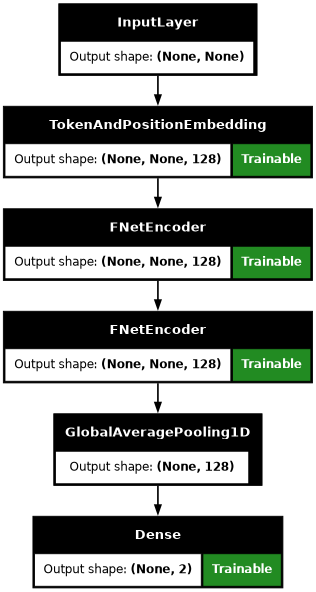

In [11]:
# plotting the model
tf.keras.utils.plot_model(model, show_shapes=True, dpi=60, show_trainable=True)

In [12]:
# training
hist = model.fit(train_dataset, validation_data = val_dataset, epochs = 15, callbacks = my_callbacks)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:847: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:847: UserWarning: Layer 'f_net_encoder' (of type FNetEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
I0000 00:00:1711025526.058792      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 16/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.6177 - loss: 0.6615

W0000 00:00:1711025526.419793      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711025526.426263      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - acc: 0.6772 - loss: 0.6241

W0000 00:00:1711025532.965253      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711025532.967458      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - acc: 0.6773 - loss: 0.6240 - val_acc: 0.6902 - val_loss: 0.5823
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.6980 - loss: 0.5585 - val_acc: 0.8518 - val_loss: 0.4387
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.8380 - loss: 0.4011 - val_acc: 0.8623 - val_loss: 0.3314
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.9102 - loss: 0.2584 - val_acc: 0.9439 - val_loss: 0.1847
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.9238 - loss: 0.2138 - val_acc: 0.9305 - val_loss: 0.1801
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - acc: 0.9281 - loss: 0.1886 - val_acc: 0.9482 - val_loss: 0.1444
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.9598 - loss: 0.1277 - val_acc: 0.9236 - val_loss: 0.2012
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.9571 - loss: 0.1195 - val_acc: 0.9305 - val_loss: 0.2211
Epoch 9/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc

# <span style="color:#e74c3c;"> Test </span>  Predictions

In [13]:
# test predictions
pred_ = model.predict(test_dataset)
pred = np.argmax(pred_, axis = 1)

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


In [14]:
# a function for calculating and plotting predictions 
def plot_prediction_results(y_true: np.array, y_pred : np.array, label_encoder) -> None:
    
    mse = mean_squared_error(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average = 'weighted')
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    clf = classification_report(y_true, y_pred, target_names = list(label_encoder.classes_))
    
    print('Mean Squared Error :\t{0:.5f}'.format(mse))
    print('Weighted F1 Score :\t{0:.3f}'.format(f1))
    print('Accuracy Score :\t{0:.3f} %'.format(acc*100))
    print('--'*35)
    
    print('\n Classification Report:\n',clf)
    print('--'*35)

    print('\n Confusion Matrix: \n')

    cmd = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels = list(label_encoder.classes_),  xticks_rotation="vertical", values_format = '2g', cmap = 'bone', colorbar = False)

# <span style="color:#e74c3c;"> Test </span>  Results

Mean Squared Error :	0.07870
Weighted F1 Score :	0.923
Accuracy Score :	92.130 %
----------------------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

         ham       0.98      0.90      0.94      2619
        spam       0.82      0.96      0.88      1193

    accuracy                           0.92      3812
   macro avg       0.90      0.93      0.91      3812
weighted avg       0.93      0.92      0.92      3812

----------------------------------------------------------------------

 Confusion Matrix: 



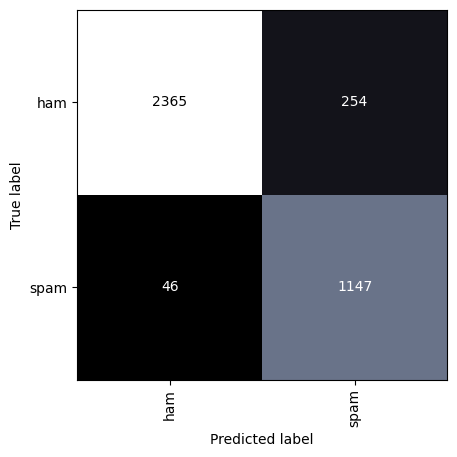

In [15]:
plot_prediction_results(test_data['encoded_text_type'], pred, LE)